# BONUS Decile Analysis


### The problem of classifying using a threshold value


Binary Logistic Regression is used as a Classification algorithm when we want the response variable to be dichotomous, Churn/Not Churned, Pass/Fail, Spam/No spam, etc...

Usually, we make Logistic Regression into a classification algorithm by setting an appropriate probability cut-off or threshold, 0.4, 0.5, 0.6, etc...

Fixing the probability threshold is purely a business call and not a statistical one. The threshold could vary from one domain/industry to another. Classification is a forced choice.

Now consider this example, you choose a threshold value of 0.5. Now the ML algorithm outputs the probability of default or no default (1- default, 0 — no default) for 4 customers as 0.51, 0.49, 0.23 and 0.92. Based on the threshold, 2 are classified as ‘default’ and 2 are classified as ‘no default’. However, ask yourself this, isn’t it too close to call for the customers with probability 0.51 and 0.49? 0.51 is surely closer to 0.49 (which is classified as no default) than it is to 0.92 (which is classified as default).

Some popular machine learning packages and low code tools do not depict the predicted probabilities to the user explicitly. The user is hence oblivious to what predicted probabilities are gotten. He /she simply gets the decision — default or no default (1 or 0). In the case of 0.49 and 0.51, the user happily made the decision that the person will not default and will default respectively. But a peek inside the predicted probabilities reveals that it was too close to call!

The other problem with thresholds is that, when we use an improper scoring rule like classification accuracy, it can be easily gamed. For e.g., if out of 100 people, 95 of them default on loan, and 5 don’t. If the classifier classifies everyone to default on loan, then it would have an accuracy of 95% !!

**So, is there a better way to use Logistic Regression?**

The answer is Yes. Industries such as Finance and Marketing use Logistic Regression in a more appropriate way for Credit risk modelling and marketing campaign targeting respectively. A real use case? Let's say, you are a CMO in charge for sales and marketing of a product in your organization. You plan to launch a marketing campaign to increase sales of that product. You have been given a fixed budget for this. Now you would like to get the best ROI possible i.e., spend the exact fixed budget or even lesser and get the maximum sales possible. Here is what you have. You have the data for 10,000 customers who had either purchased or not purchased a similar product in the past. You would like to understand which customers should be targeted to increase the likelihood of purchase this time. You would obviously like to target those people who are more likely to buy the product since you have a fixed budget for the campaign. How to go about it?

Decile Analysis and Gain Chart come to rescue here.

### What is a Decile Analysis?

Decile analysis was once a popularly used technique, however the convention of teaching and bucketing machine learning problems into either ‘classification’ or ‘Regression’ types, lead people to forget Decile analysis type analyses. I am pretty sure, most freshly minted data scientists would not have even heard of Decile analysis. So, coming back to what is Decile Analysis.

Decile Analysis is used to categorize dataset from highest to lowest values or vice versa. (Based on predicted probabilities)

As obvious from the name, the analysis involves dividing the dataset into ten equal groups. Each group should have the same no. of observations/customers.

It ranks customers in the order from most likely to respond to least likely to respond.

How is Decile Analysis done?

**Step 1**: Build a Logistic Regression model. In this case the dependent variable was ‘probability of buying the product’. With 1 denoting purchased, 0 denoting not purchased. Also, the relevant independent variables were selected.

**Step 2**: Get the predicted probabilities from Logistic Regression algorithm. Arrange the probabilities in descending order.

**Step 3**: Divide the whole dataset into 10 groups, each group should contain equal no. of observations. So, if there 10,000 records, each group would have 1000 records/customers.

**Step 4**: Compute % of responders for each decile

**Step 5**: Compute response rate for each decile

**Step 6**: Compute lift for each decile


The top decile would have customers who are most likely to respond followed by the decile 2 which would have customers who are next most likely to respond and so on.

One major advantage of the decile analysis is that the probabilities and probability range are their own error measures. That is, if the top decile has the probability range 0.75–0.81, then then the probability of this person not buying the product i.e., the error would be (1- [0.75–0.81], here ‘[]’ denotes the interval of values between 0.75–0.81 including 0.75 and 0.81)


Let's do it.

In [1]:
import pandas as pd                                # panel data, for handling dataframes
pd.set_option('display.max_columns', None)         # show all columns of the dataframe

import numpy as np                                 # numerical python, linear algebra library

import pylab as plt                                # plotting library
import seaborn as sns                              # plotting library
sns.set(style='white')                             # seaborn style

from sqlalchemy import create_engine               # connection engine for SQL server


from sklearn.linear_model import LogisticRegression            # logistic regression model      

from sklearn.preprocessing import StandardScaler               # standarized
from sklearn.preprocessing import LabelEncoder               
from sklearn.model_selection import train_test_split as tts    # split data into train and test sets


### Accesing data

In [2]:
DB_LANG='mysql'             # database language

DRIVER='pymysql'            # database driver

USER='root'                 # user name

PASSWORD='password'         # user password

HOST='localhost'            # host SQL server

PORT='3306'                 # host port

SCHEMA='telcom'             # database schema name

In [3]:
connection_string=f'{DB_LANG}+{DRIVER}://{USER}:{PASSWORD}@{HOST}:{PORT}/{SCHEMA}'

        
engine=create_engine(connection_string)   # connection engine

In [4]:
df=pd.read_sql('select * from temporary_table', engine)

### Data transformation

In [5]:
def change_all_dtypes(df):   
    '''
    This function change all dtypes to float if it can.
    
    input param df:  dataframe to be change
    
    returns: clean dataframe
    '''
    
    for c in df.columns:
        try:
            df[c]=df[c].astype(float)
        except:
            continue
            
    return df

In [6]:
df=change_all_dtypes(df)   # change dtypes

In [7]:
# dropping columns

data=df.drop(columns=['CustomerID',
                      'MonthlyMinutes',
                      'HandsetModels',
                      'id',
                      'Handsets',
                      'ReceivedCalls',
                      'MonthsInService',
                      'ServiceArea'
                     ])

In [8]:
data_num=pd.DataFrame(StandardScaler().fit_transform(data._get_numeric_data()),  # standardize numeric columns
                      columns=data._get_numeric_data().columns)

data_obj=data.select_dtypes(include='object')  # get categoric columns


data=pd.concat([data_num, data_obj], axis=1)   # concatenate both dataframes

In [9]:
# label encoding 

le=LabelEncoder()

for c in data.columns:
    if data.dtypes[c]==object:
        le.fit(data[c].astype(str))
        data[c]=le.transform(data[c].astype(str))

In [10]:
data.head()

,MonthlyRevenue,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,UniqueSubs,ActiveSubs,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,SeniorCitizen,Tenure,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,Gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureLevel
0,-0.783391,-1.045275,-0.288506,-0.413714,-0.124522,-0.568070,-0.452482,-0.587674,-0.311711,-0.565902,-0.366649,-0.254828,-0.723803,-0.492182,-0.310234,-0.471357,-0.572545,-0.020214,-0.274974,0.384227,-0.525372,-0.075394,1.387951,-0.883862,4.775674,-0.128321,-0.193162,-0.129459,-0.140293,-0.438968,1.327621,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,8,1,0,2,4,0,0,0,0,0,2,2,2,2,2,2,2,1,0,3
1,-0.941570,-1.255720,-0.400881,-0.413714,-0.124522,0.029924,0.029852,-0.631939,-0.376308,-0.658542,-0.366649,-0.254828,-0.723803,-0.492182,-0.816926,-0.719375,-0.637245,-0.020214,-0.328636,-0.431548,-0.525372,4.455151,0.392087,0.871525,-0.175756,-0.128321,-0.193162,0.192036,-0.140293,-0.438968,0.838668,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,8,0,3,2,4,2,1,0,1,0,2,2,0,2,0,0,1,0,1,0
2,-0.467484,-0.371853,-0.400881,-0.413714,-0.124522,0.037741,0.029852,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.715237,-0.492182,-0.852299,-0.690260,-0.656655,-0.020214,-0.328636,-0.431548,-0.525372,5.675981,-0.241644,0.202806,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,-1.280129,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,15,0,2,3,1,2,0,0,0,0,0,0,0,0,0,2,0,1,2,1
3,0.531686,1.185434,0.156497,-0.413714,-0.124522,0.659185,0.235479,5.089263,0.334262,1.227715,0.474635,0.855266,9.849010,8.370346,4.447898,2.544760,3.205954,-0.020214,3.731853,0.384227,0.972010,0.309088,-0.060578,-0.883862,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,0.105238,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,3,0,3,0,0,1,1,2,1,1,1,1,1,1,2,0,1,2
4,-0.938185,-1.255720,-0.400881,-0.413714,-0.124522,0.045558,0.024775,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.723803,-0.492182,-0.864728,-0.730159,-0.656655,-0.020214,-0.328636,0.384227,0.972010,1.870799,0.663686,1.373064,-0.175756,-0.128321,-0.193162,1.478017,2.472906,-0.438968,-0.017000,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,4,2,0,0,0,1,2,0,2,2,2,2,1,1,0,0


### Modeling

**Step 1**

In [11]:
X=data.drop('Churn', axis=1)   # all data except target

y=data.Churn                   # target data

In [12]:
X_train, X_test, y_train, y_test = tts(X, y, random_state=42)   # split data into train and test sets

In [13]:
# logistic regression model

logreg=LogisticRegression(max_iter=2000)

logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)

0.7069464544138929

We already know how this model works.

**Step 2**

In [14]:
logreg.predict_proba(X)[0]

array([0.53139167, 0.46860833])

In [15]:
data['churn_proba']=[e[1] for e in logreg.predict_proba(X)]

data.head()

,MonthlyRevenue,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,UniqueSubs,ActiveSubs,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,SeniorCitizen,Tenure,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,Gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureLevel,churn_proba
0,-0.783391,-1.045275,-0.288506,-0.413714,-0.124522,-0.568070,-0.452482,-0.587674,-0.311711,-0.565902,-0.366649,-0.254828,-0.723803,-0.492182,-0.310234,-0.471357,-0.572545,-0.020214,-0.274974,0.384227,-0.525372,-0.075394,1.387951,-0.883862,4.775674,-0.128321,-0.193162,-0.129459,-0.140293,-0.438968,1.327621,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,8,1,0,2,4,0,0,0,0,0,2,2,2,2,2,2,2,1,0,3,0.468608
1,-0.941570,-1.255720,-0.400881,-0.413714,-0.124522,0.029924,0.029852,-0.631939,-0.376308,-0.658542,-0.366649,-0.254828,-0.723803,-0.492182,-0.816926,-0.719375,-0.637245,-0.020214,-0.328636,-0.431548,-0.525372,4.455151,0.392087,0.871525,-0.175756,-0.128321,-0.193162,0.192036,-0.140293,-0.438968,0.838668,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,8,0,3,2,4,2,1,0,1,0,2,2,0,2,0,0,1,0,1,0,0.534212
2,-0.467484,-0.371853,-0.400881,-0.413714,-0.124522,0.037741,0.029852,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.715237,-0.492182,-0.852299,-0.690260,-0.656655,-0.020214,-0.328636,-0.431548,-0.525372,5.675981,-0.241644,0.202806,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,-1.280129,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,15,0,2,3,1,2,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0.632674
3,0.531686,1.185434,0.156497,-0.413714,-0.124522,0.659185,0.235479,5.089263,0.334262,1.227715,0.474635,0.855266,9.849010,8.370346,4.447898,2.544760,3.205954,-0.020214,3.731853,0.384227,0.972010,0.309088,-0.060578,-0.883862,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,0.105238,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,3,0,3,0,0,1,1,2,1,1,1,1,1,1,2,0,1,2,0.164322
4,-0.938185,-1.255720,-0.400881,-0.413714,-0.124522,0.045558,0.024775,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.723803,-0.492182,-0.864728,-0.730159,-0.656655,-0.020214,-0.328636,0.384227,0.972010,1.870799,0.663686,1.373064,-0.175756,-0.128321,-0.193162,1.478017,2.472906,-0.438968,-0.017000,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,4,2,0,0,0,1,2,0,2,2,2,2,1,1,0,0,0.360399


**Step 3**

In [16]:
data['decile_interval']=pd.qcut(data['churn_proba'], q=10)

data['decile']=pd.qcut(data['churn_proba'], q=10, labels=[i+1 for i in range(10)])

data.head()

,MonthlyRevenue,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,UniqueSubs,ActiveSubs,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,SeniorCitizen,Tenure,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,Gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureLevel,churn_proba,decile_interval,decile
0,-0.783391,-1.045275,-0.288506,-0.413714,-0.124522,-0.568070,-0.452482,-0.587674,-0.311711,-0.565902,-0.366649,-0.254828,-0.723803,-0.492182,-0.310234,-0.471357,-0.572545,-0.020214,-0.274974,0.384227,-0.525372,-0.075394,1.387951,-0.883862,4.775674,-0.128321,-0.193162,-0.129459,-0.140293,-0.438968,1.327621,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,8,1,0,2,4,0,0,0,0,0,2,2,2,2,2,2,2,1,0,3,0.468608,"(0.389, 1.0]",10
1,-0.941570,-1.255720,-0.400881,-0.413714,-0.124522,0.029924,0.029852,-0.631939,-0.376308,-0.658542,-0.366649,-0.254828,-0.723803,-0.492182,-0.816926,-0.719375,-0.637245,-0.020214,-0.328636,-0.431548,-0.525372,4.455151,0.392087,0.871525,-0.175756,-0.128321,-0.193162,0.192036,-0.140293,-0.438968,0.838668,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,8,0,3,2,4,2,1,0,1,0,2,2,0,2,0,0,1,0,1,0,0.534212,"(0.389, 1.0]",10
2,-0.467484,-0.371853,-0.400881,-0.413714,-0.124522,0.037741,0.029852,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.715237,-0.492182,-0.852299,-0.690260,-0.656655,-0.020214,-0.328636,-0.431548,-0.525372,5.675981,-0.241644,0.202806,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,-1.280129,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,15,0,2,3,1,2,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0.632674,"(0.389, 1.0]",10
3,0.531686,1.185434,0.156497,-0.413714,-0.124522,0.659185,0.235479,5.089263,0.334262,1.227715,0.474635,0.855266,9.849010,8.370346,4.447898,2.544760,3.205954,-0.020214,3.731853,0.384227,0.972010,0.309088,-0.060578,-0.883862,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,0.105238,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,3,0,3,0,0,1,1,2,1,1,1,1,1,1,2,0,1,2,0.164322,"(0.00429, 0.196]",1
4,-0.938185,-1.255720,-0.400881,-0.413714,-0.124522,0.045558,0.024775,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.723803,-0.492182,-0.864728,-0.730159,-0.656655,-0.020214,-0.328636,0.384227,0.972010,1.870799,0.663686,1.373064,-0.175756,-0.128321,-0.193162,1.478017,2.472906,-0.438968,-0.017000,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,4,2,0,0,0,1,2,0,2,2,2,2,1,1,0,0,0.360399,"(0.343, 0.389]",9


**Step 4 and 5**

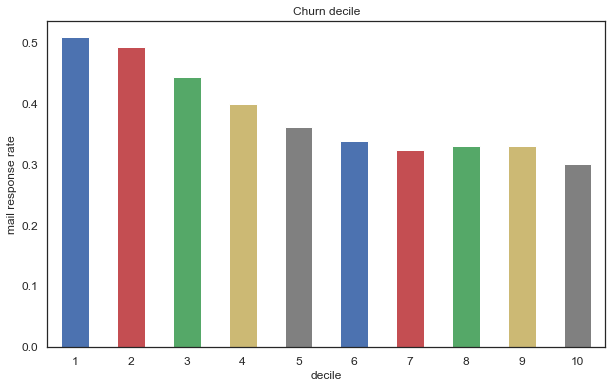

In [17]:
data.groupby('decile').mean()['RespondsToMailOffers'].plot.bar(color=['b', 'r', 'g', 'y', 'grey'],   
                                                               ylabel='mail response rate',
                                                               figsize=(10, 6),
                                                               title='Churn decile',
                                                               rot=0,
                                                               fontsize=12);

In [25]:
resp_mean=data.groupby('decile').mean()['RespondsToMailOffers']

decile_lift=[resp_mean[i+1] - resp_mean[i+2] for i in range(len(resp_mean)-1)][1:]

**Step 6**

In [27]:
decile_lift

[0.04924623115577886,
 0.045025125628140705,
 0.037386934673366845,
 0.023316582914572892,
 0.014874371859296465,
 -0.006834170854271349,
 0.0,
 0.029809255279613478]

**How to use Decile Analysis in business decision making:**

Now that we have done building Decile Analysis, the next pertinent question is how we use it to make effective business decisions. Going by the above results, we make a decision that we will target customers in the Top 4 deciles as they have higher probability of buying the product.

From the business point of view, the ROI of targeting the Top 4 deciles is more. As we move down the decile, the ROI rapidly decreases and is not worthwhile pursuing these customers.

### Reference: 
https://www.datasciencecentral.com/profiles/blogs/the-lost-art-of-decile-analysis